In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.measure import label
from skimage.morphology import remove_small_objects
import os
from skimage import morphology, filters, io
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray, rgba2rgb
import matplotlib.pyplot as plt
from PIL import Image
import random
from skimage.morphology import skeletonize
from skan import Skeleton, summarize

-- -- -- -- -- POST PROCESSING -- -- -- -- --

In [3]:
# Percorso base alle cartelle con le tue immagini
base_path = '/content/drive/MyDrive/Progetto/RETINA/reconstructed512'
output_base_path = '/content/drive/MyDrive/Progetto/RETINA/post_processed'  # Cartella di output

# Crea la cartella di output e le sottocartelle se non esistono
if not os.path.exists(output_base_path):
    os.makedirs(output_base_path)

for set_name in ['train', 'test', 'val']:
    set_output_path = os.path.join(output_base_path, set_name)
    if not os.path.exists(set_output_path):
        os.makedirs(set_output_path)

# Definisci le cartelle dei set
sets = ['train', 'test', 'val']


# Let's define a function to perform the post processing steps on the mask
def optimized_post_process_mask(mask, kernel_size=3):
    # Crea un kernel ellittico per operazioni morfologiche
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

    # Connessione dei segmenti dei vasi con closing morfologico
    closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel1)

    # Rimozione del rumore con opening morfologico utilizzando un kernel più piccolo
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel2)

    # Utilizzo delle componenti connesse per filtrare ulteriormente il rumore
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening, connectivity=8)
    new_mask = np.zeros_like(mask)

    # Soglia basata sull'area per mantenere componenti significative
    area_threshold = 100
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= area_threshold:
            new_mask[labels == label] = 255

    return new_mask


# Processa le immagini in ogni cartella
for set_name in sets:
    folder_path = os.path.join(base_path, set_name)
    output_folder_path = os.path.join(output_base_path, set_name)

    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            # Carica l'immagine come binaria
            image = cv2.imread(image_path, 0)
            processed_image = optimized_post_process_mask(image)

            # Salva l'immagine processata
            save_path = os.path.join(output_folder_path, filename)
            cv2.imwrite(save_path, processed_image)


print('Post-processing completed for all images.')

Post-processing completed for all images.


-- -- metriche post-processing -- --

In [4]:
def calculate_metrics(mask_gt, reconstructed_mask):
    intersection = np.logical_and(mask_gt, reconstructed_mask)
    union = np.logical_or(mask_gt, reconstructed_mask)
    iou = np.sum(intersection) / np.sum(union)
    accuracy = np.sum(mask_gt == reconstructed_mask) / mask_gt.size
    precision = np.sum(intersection) / np.sum(reconstructed_mask)
    sensitivity = np.sum(intersection) / np.sum(mask_gt)
    dice = 2 * np.sum(intersection) / (np.sum(mask_gt) + np.sum(reconstructed_mask))
    return iou, accuracy, precision, sensitivity, dice

In [5]:
base_path = '/content/drive/MyDrive/Progetto/RETINA'

# Percorsi alle cartelle con le maschere ground truth e le maschere ricostruite
gt_masks_folders = [
    os.path.join(base_path, 'training', 'train_y'),
    os.path.join(base_path, 'validation', 'validation_y'),
    os.path.join(base_path, 'test', 'test_y')
]
reconstructed_masks_folders = [
    os.path.join(base_path, 'post_processed', 'train'),
    os.path.join(base_path, 'post_processed', 'val'),
    os.path.join(base_path, 'post_processed', 'test')
]

# Dizionario per memorizzare le metriche
metrics = {'iou': [], 'accuracy': [], 'precision': [], 'sensitivity': [], 'dice': []}

# Contatore per gli elementi non presi
missing_elements_count = 0

def prepare_image(path):
    """
    Carica un'immagine, la converte in scala di grigi se necessario, e la ridimensiona.
    """
    image = imread(path)
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    if len(image.shape) > 2:
        image = rgb2gray(image)
    image_resized = resize(image, (512, 512), anti_aliasing=True)
    image_bin = image_resized > 0.5
    return image_bin


for gt_folder, reconstructed_folder in zip(gt_masks_folders, reconstructed_masks_folders):
    reconstructed_filenames_set = {os.path.splitext(fname.replace('_patch', ''))[0] for fname in os.listdir(reconstructed_folder) if fname.endswith('.png')}

    for fname in os.listdir(gt_folder):
        if not fname.endswith('.png') or fname == "448_G.png":
            continue

        base_fname = os.path.splitext(fname)[0]

        if base_fname in reconstructed_filenames_set:
            ground_truth_path = os.path.join(gt_folder, fname)
            reconstructed_mask_path = os.path.join(reconstructed_folder, base_fname + '.png')

            mask_gt = prepare_image(ground_truth_path)
            reconstructed_mask = prepare_image(reconstructed_mask_path)

            iou, accuracy, precision, sensitivity, dice = calculate_metrics(mask_gt, reconstructed_mask)

            metrics['iou'].append(iou)
            metrics['accuracy'].append(accuracy)
            metrics['precision'].append(precision)
            metrics['sensitivity'].append(sensitivity)
            metrics['dice'].append(dice)
        else:
            missing_elements_count += 1

# Stampa le metriche complessive
print("Metrics for the combined dataset:")
for metric_name, metric_values in metrics.items():
    if metric_values:  # Verifica che la lista non sia vuota
        mean_value = np.mean(metric_values)
        std_value = np.std(metric_values)
        print(f"{metric_name.capitalize()}: mean = {mean_value:.4f} +/- {std_value:.4f}")
    else:
        print(f"{metric_name.capitalize()}: No data")
print(f"\nMissing elements: {missing_elements_count}")


Metrics for the combined dataset:
Iou: mean = 0.8160 +/- 0.1088
Accuracy: mean = 0.9856 +/- 0.0102
Precision: mean = 0.9049 +/- 0.0666
Sensitivity: mean = 0.8894 +/- 0.1150
Dice: mean = 0.8935 +/- 0.0881

Missing elements: 0


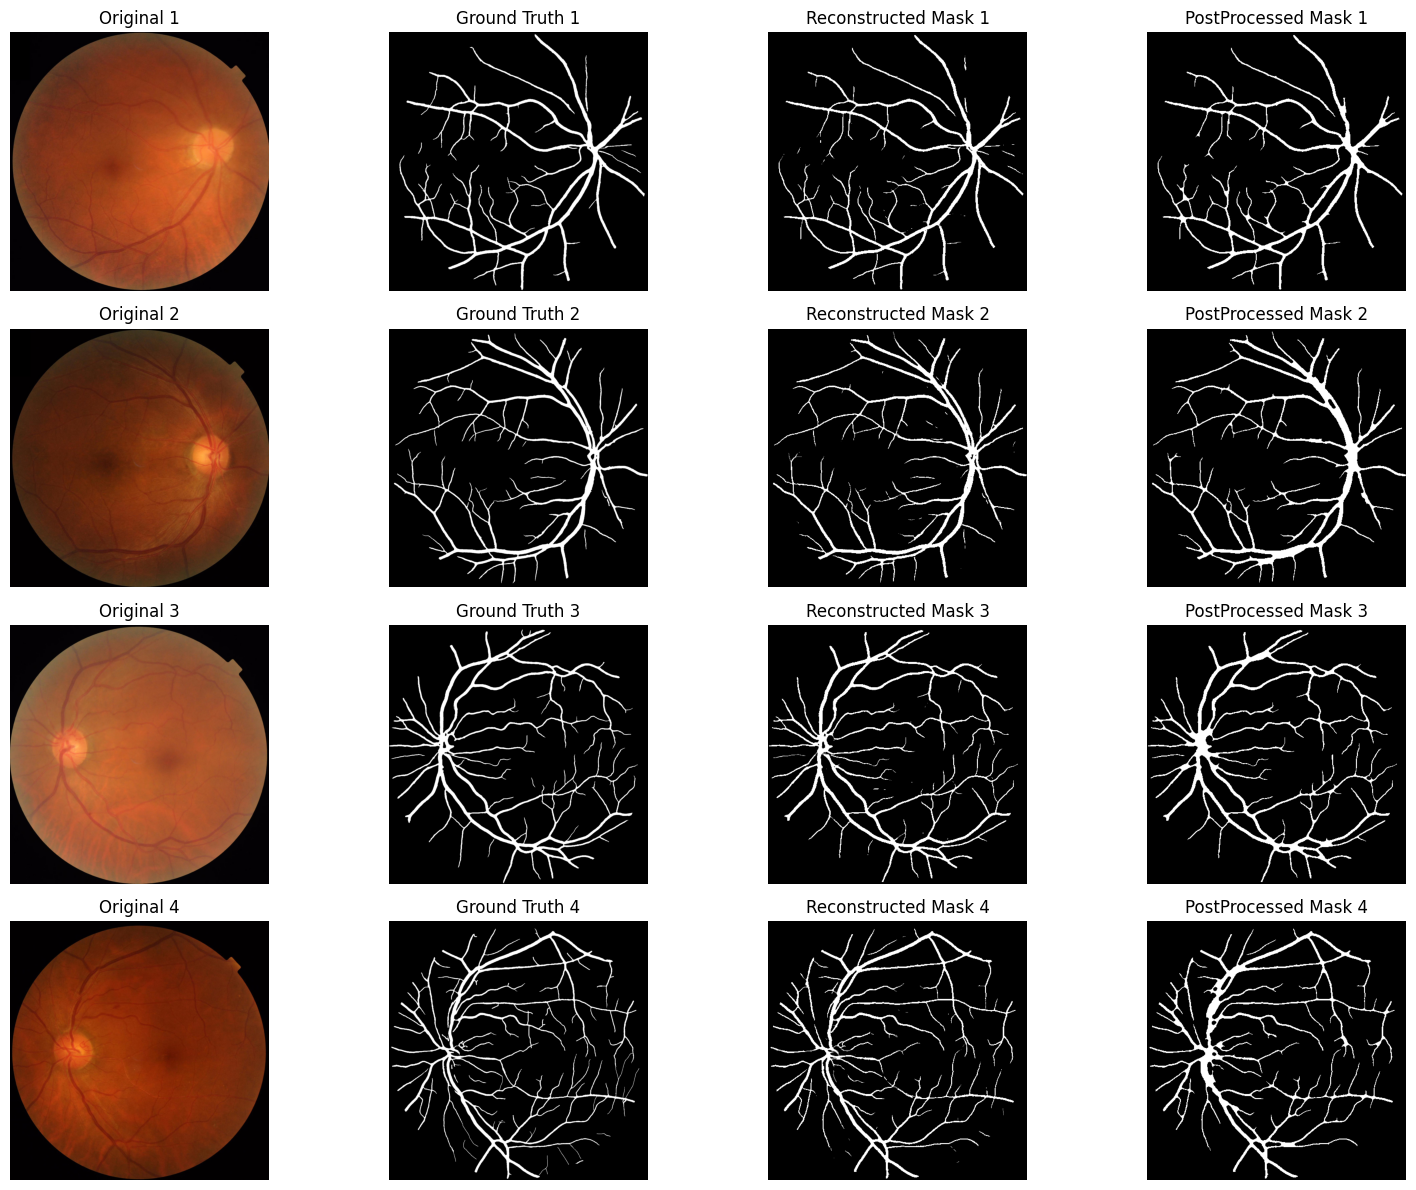

In [6]:
# Percorsi delle directory
original_images_dir = '/content/drive/MyDrive/Progetto/RETINA/test/test_x'
ground_truth_dir = '/content/drive/MyDrive/Progetto/RETINA/test/test_y'
reconstructed_masks_dir = '/content/drive/MyDrive/Progetto/RETINA/reconstructed512/test'
post_processed = '/content/drive/MyDrive/Progetto/RETINA/post_processed7/test'

# Ottieni l'elenco completo dei file e seleziona casualmente 4 file
all_original_files = sorted(os.listdir(original_images_dir))
all_ground_truth_files = sorted(os.listdir(ground_truth_dir))
all_reconstructed_files = sorted(os.listdir(reconstructed_masks_dir))
all_post_processed_files = sorted(os.listdir(post_processed))

selected_indices = random.sample(range(len(all_original_files)), 4)  # Assicurati che il range sia valido per tutte le liste

original_images_files = [all_original_files[i] for i in selected_indices]
ground_truth_files = [all_ground_truth_files[i] for i in selected_indices]
reconstructed_masks_files = [all_reconstructed_files[i] for i in selected_indices]
post_processed_files = [all_post_processed_files[i] for i in selected_indices]

# Crea una figura con subplot per le immagini selezionate
plt.figure(figsize=(16, 12))  # Aumenta la dimensione per una migliore visualizzazione

for i in range(4):
    # Immagine originale RGB
    plt.subplot(4, 4, 4 * i + 1)
    original_image = Image.open(os.path.join(original_images_dir, original_images_files[i]))
    plt.imshow(original_image)
    plt.title(f'Original {i+1}')
    plt.axis('off')

    # Ground truth
    plt.subplot(4, 4, 4 * i + 2)
    ground_truth_image = Image.open(os.path.join(ground_truth_dir, ground_truth_files[i]))
    plt.imshow(ground_truth_image, cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')

    # Maschera ricostruita
    plt.subplot(4, 4, 4 * i + 3)
    reconstructed_mask = Image.open(os.path.join(reconstructed_masks_dir, reconstructed_masks_files[i]))
    plt.imshow(reconstructed_mask, cmap='gray')
    plt.title(f'Reconstructed Mask {i+1}')
    plt.axis('off')

    # PostProcessed mask
    plt.subplot(4, 4, 4 * i + 4)
    postprocessed_mask = Image.open(os.path.join(post_processed, post_processed_files[i]))
    plt.imshow(postprocessed_mask, cmap='gray')
    plt.title(f'PostProcessed Mask {i+1}')
    plt.axis('off')

# Mostra il plot
plt.tight_layout()
plt.show()

-- -- -- -- -- ESTRAZIONE ALBERO VASCOLARE -- -- -- -- --

In [7]:
pip install skan

In [8]:
def analyze_image(image_path, target_shape=(512, 512)):
    # Legge l'immagine come scala di grigi
    image = imread(image_path, as_gray=True)
    # Ridimensiona l'immagine alla forma target
    image_resized = resize(image, target_shape, anti_aliasing=True)

    # Controlla se l'immagine ridimensionata è completamente nera
    if np.max(image_resized) == 0:
        return 0, 0, False  # Aggiunge un terzo valore di ritorno per indicare che l'immagine non è stata processata

    skeleton_image = skeletonize(image_resized > 0)
    labeled_skeleton = label(skeleton_image)
    if labeled_skeleton.max() == 0:
        return 0, 0, False

    skel = Skeleton(skeleton_image)
    stats = summarize(skel)

    jj_count = np.sum(stats['branch-type'] == 1)
    je_count = np.sum(stats['branch-type'] == 2)

    return jj_count, je_count, True  # L'immagine è stata processata con successo

def calculate_relative_error(true_counts, pred_counts):
    error = np.where(true_counts == 0, np.nan, np.abs(true_counts - pred_counts) / true_counts)
    return error

# Assumi che queste cartelle siano correttamente popolate con i percorsi dei file
base_path = '/content/drive/MyDrive/Progetto/RETINA'
gt_masks_folders = [
    os.path.join(base_path, 'training', 'train_y'),
    os.path.join(base_path, 'validation', 'validation_y'),
    os.path.join(base_path, 'test', 'test_y')
]
reconstructed_masks_folders = [
    os.path.join(base_path, 'post_processed', 'train'),
    os.path.join(base_path, 'post_processed', 'val'),
    os.path.join(base_path, 'post_processed', 'test')
]

# Funzione per ottenere tutti i percorsi dei file da una lista di cartelle
def get_all_file_paths(folders_list):
    all_files = []
    for folder in folders_list:
        for filename in os.listdir(folder):
            all_files.append(os.path.join(folder, filename))
    return all_files

# Ottieni tutti i percorsi dei file per le maschere GT e ricostruite
gt_files = get_all_file_paths(gt_masks_folders)
reconstructed_files = get_all_file_paths(reconstructed_masks_folders)

# Assicurati che le liste siano ordinate per assicurare la corrispondenza dei file
gt_files.sort()
reconstructed_files.sort()

# Inizializza i conteggi
true_jj_counts = []
true_je_counts = []
pred_jj_counts = []
pred_je_counts = []

for gt_path, reconstructed_path in zip(gt_files, reconstructed_files):
    gt_jj, gt_je, gt_processed = analyze_image(gt_path)
    pred_jj, pred_je, pred_processed = analyze_image(reconstructed_path)

    if gt_processed and pred_processed:  # Aggiungi i conteggi solo se entrambe le immagini sono state processate
        true_jj_counts.append(gt_jj)
        true_je_counts.append(gt_je)
        pred_jj_counts.append(pred_jj)
        pred_je_counts.append(pred_je)


# Calcolo degli errori relativi
jj_error = calculate_relative_error(np.array(true_jj_counts), np.array(pred_jj_counts))
je_error = calculate_relative_error(np.array(true_je_counts), np.array(pred_je_counts))

# Calcolo di media e deviazione standard degli errori
jj_mean_error, jj_std_error = np.mean(jj_error), np.std(jj_error)
je_mean_error, je_std_error = np.mean(je_error), np.std(je_error)

print(f"Errore relativo medio Junction-to-Junction: {jj_mean_error:.4f} ± {jj_std_error:.4f}")
print(f"Errore relativo medio Junction-to-Endpoint: {je_mean_error:.4f} ± {je_std_error:.4f}")


Errore relativo medio Junction-to-Junction: 0.1787 ± 0.1283
Errore relativo medio Junction-to-Endpoint: 0.3463 ± 0.1439


 -- -- PLOT DI ESEMPIO -- --

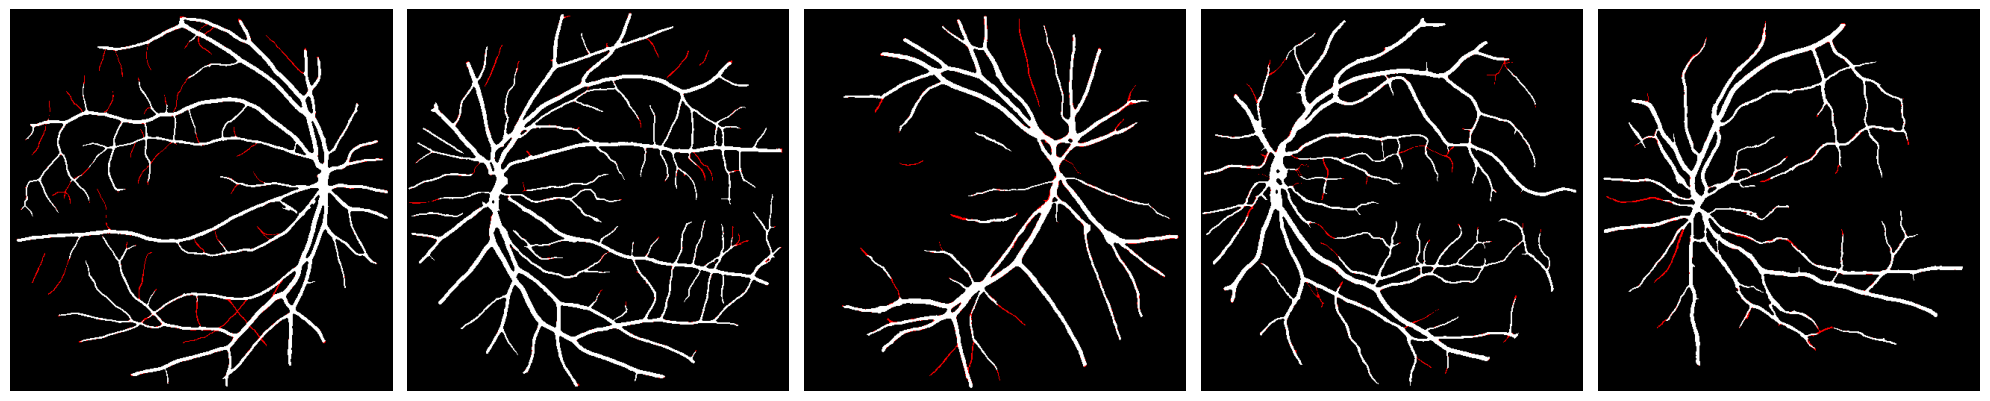

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import random

indices = random.sample(range(min(len(gt_files), len(reconstructed_files))), 5)


plt.figure(figsize=(20, 10))

for i, index in enumerate(indices):
    # Leggi l'immagine originale e quella ricostruita
    gt_image = imread(gt_files[index], as_gray=True)
    reconstructed_image = imread(reconstructed_files[index], as_gray=True)

    # Ridimensiona l'immagine ground truth a 512x512 per il matching con quella ricostruita
    gt_image_resized = resize(gt_image, (512, 512), anti_aliasing=True, preserve_range=True)

    # Converte le immagini in binario per la sovrapposizione
    gt_image_bin = gt_image_resized > 0.5  # Aggiusta la soglia se necessario
    reconstructed_image_bin = reconstructed_image > 0.5  # Aggiusta la soglia se necessario

    # Crea un'immagine RGB per la visualizzazione
    overlay_image = np.zeros((512, 512, 3), dtype=np.uint8)  # Dimensioni corrispondenti alle immagini ridimensionate

    # Assegna il rosso alla maschera originale (ground truth)
    overlay_image[gt_image_bin] = [255, 0, 0]  # Rosso

    # Assegna il bianco alla maschera ricostruita
    overlay_image[reconstructed_image_bin] = [255, 255, 255]  # Bianco

    # Mostra l'immagine
    plt.subplot(2, 5, i + 1)
    plt.imshow(overlay_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


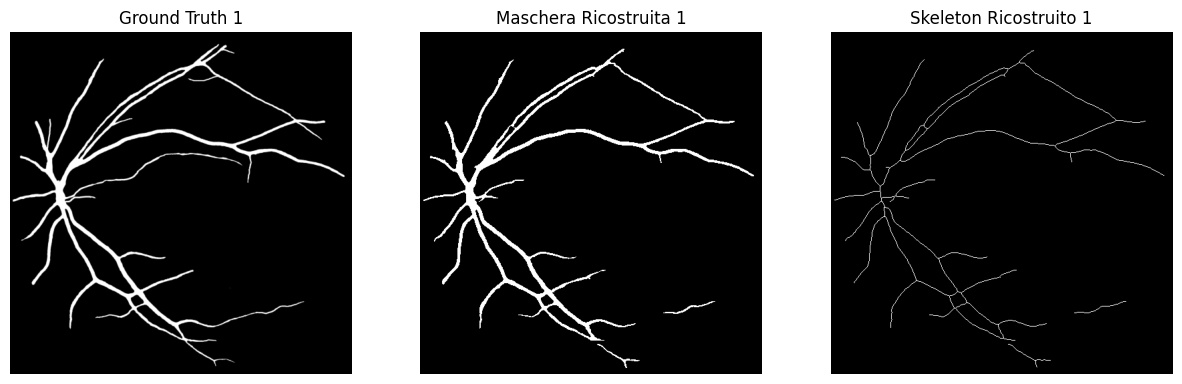

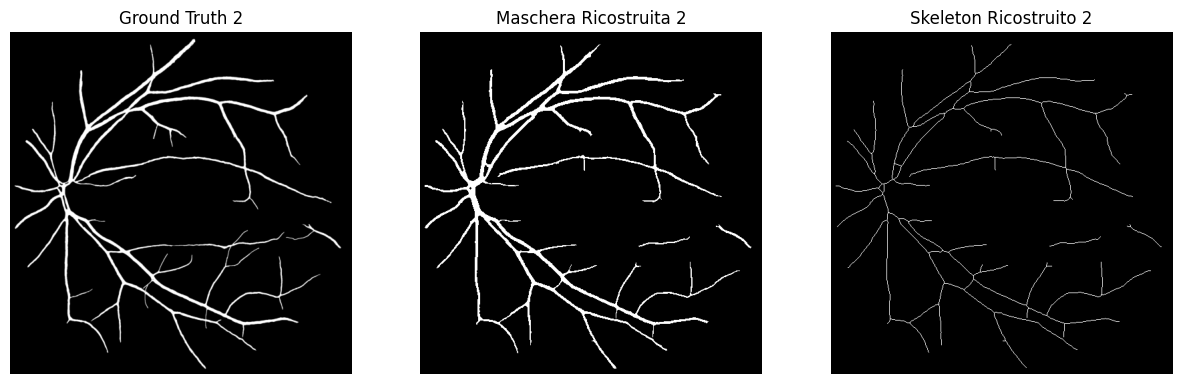

In [10]:
import matplotlib.pyplot as plt

# Funzione modificata per visualizzare lo skeleton insieme alla maschera ricostruita e al ground truth
def plot_images_and_skeletons(gt_path, reconstructed_path, image_number):
    # Leggi e ridimensiona l'immagine ground truth e la maschera ricostruita
    gt_image = imread(gt_path, as_gray=True)
    gt_image_resized = resize(gt_image, (512, 512), anti_aliasing=True)

    reconstructed_image = imread(reconstructed_path, as_gray=True)
    reconstructed_image_resized = resize(reconstructed_image, (512, 512), anti_aliasing=True)

    # Calcola lo skeleton per l'immagine ricostruita
    skeleton_reconstructed = skeletonize(reconstructed_image_resized > 0)

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine Ground Truth
    axs[0].imshow(gt_image_resized, cmap='gray')
    axs[0].set_title(f"Ground Truth {image_number}")
    axs[0].axis('off')

    # Immagine Ricostruita
    axs[1].imshow(reconstructed_image_resized, cmap='gray')
    axs[1].set_title(f"Maschera Ricostruita {image_number}")
    axs[1].axis('off')

    # Skeleton dell'Immagine Ricostruita
    axs[2].imshow(skeleton_reconstructed, cmap='gray')
    axs[2].set_title(f"Skeleton Ricostruito {image_number}")
    axs[2].axis('off')

    plt.show()

# Selezioniamo solo due immagini per la demo
gt_sample_paths = gt_files[:2]
reconstructed_sample_paths = reconstructed_files[:2]

# Eseguiamo il plot per le prime due immagini selezionate
for i, (gt_path, reconstructed_path) in enumerate(zip(gt_sample_paths, reconstructed_sample_paths), start=1):
    plot_images_and_skeletons(gt_path, reconstructed_path, i)
